In [74]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [75]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [76]:
print(train.shape)
print(test.shape)

(1000000, 7)
(200000, 6)


In [77]:
print(train.head())
test.head()


       pickup_datetime  NumberOfPassengers  duration    pickup_x    pickup_y  \
0  2034-06-07 20:47:29                   1       434  135.428113  321.190773   
1  2034-04-14 08:00:21                   1       415  148.781291  322.565536   
2  2034-04-20 18:57:16                   2       398  124.000006  313.347763   
3  2034-04-28 22:40:52                   1       746  124.288413  316.495404   
4  2034-05-28 11:39:56                   1       102  177.344861  358.087844   

    dropoff_x   dropoff_y  
0  141.317712  321.357802  
1  157.145868  337.052655  
2  131.362606  300.613585  
3  143.284351  334.542116  
4  168.709489  363.038196  


,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2034-03-14 08:28:17,2,155.108652,322.284140,148.058424,332.814003
1,2034-04-20 09:04:41,1,146.628808,306.343423,154.284090,339.899155
2,2034-01-25 00:46:04,2,132.028079,319.183942,149.318583,384.810789
3,2034-02-01 22:20:46,2,175.776769,344.277029,159.039740,311.756787
4,2034-04-15 23:29:21,2,128.428489,295.153348,126.011933,309.548102


change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`)

In [78]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [79]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [80]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1     99525
 2    147047
 3    178354
 4    172556
 5    173839
 6    161219
 7     67460
 dtype: int64,
 Month
 1    19804
 2    29520
 3    35583
 4    34252
 5    35173
 6    32148
 7    13520
 dtype: int64)

In [81]:
#No of days in a month
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [82]:
#24 hours
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [83]:
#No of days
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

In [84]:
train = train.assign(log_duration = np.log(train.duration+1))

In [85]:
train.head()

,pickup_datetime,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,log_duration
0,2034-06-07 20:47:29,1,434,135.428113,321.190773,141.317712,321.357802,6,7,20,2,6.075346
1,2034-04-14 08:00:21,1,415,148.781291,322.565536,157.145868,337.052655,4,14,8,4,6.030685
2,2034-04-20 18:57:16,2,398,124.000006,313.347763,131.362606,300.613585,4,20,18,3,5.988961
3,2034-04-28 22:40:52,1,746,124.288413,316.495404,143.284351,334.542116,4,28,22,4,6.616065
4,2034-05-28 11:39:56,1,102,177.344861,358.087844,168.709489,363.038196,5,28,11,6,4.634729


In [86]:
test.head()

,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek
0,2034-03-14 08:28:17,2,155.108652,322.284140,148.058424,332.814003,3,14,8,1
1,2034-04-20 09:04:41,1,146.628808,306.343423,154.284090,339.899155,4,20,9,3
2,2034-01-25 00:46:04,2,132.028079,319.183942,149.318583,384.810789,1,25,0,2
3,2034-02-01 22:20:46,2,175.776769,344.277029,159.039740,311.756787,2,1,22,2
4,2034-04-15 23:29:21,2,128.428489,295.153348,126.011933,309.548102,4,15,23,5


# features :
1) Day of the week - weekday/weekend
2) Time of the day - 
3) Distance between point a and point b
4) Pickup location - congestion or non congestion
5) Locality - Clusters
6) Weather - Temperature - will be unknown for Gotham City

In [87]:
def rushhour(df):
  if df['Hour'] <= 6:
    return(1)
  elif df['Hour'] <= 12:
    return(2)
  elif df['Hour'] <=18:
    return(3)
  else:
    return(4)

In [88]:
# rush vs non-rush hour
train['rushhr']= train.apply(rushhour, axis=1)
test['rushhr']= test.apply(rushhour, axis=1)

In [89]:
#Weekday/Weekend
def weekdayend(df):
  if (df['dayofweek'] == 1) or (df['dayofweek'] == 2) or (df['dayofweek'] == 3) or (df['dayofweek'] == 7):
    return(0)
  else:
    return(1)

In [90]:
train['weekendweekday']= train.apply(weekdayend, axis=1)
test['weekendweekday']= test.apply(weekdayend, axis=1)

In [91]:
time_train = pd.DataFrame(index = range(len(train)))
time_test = pd.DataFrame(index = range(len(test)))

In [92]:
#calculate the route distance - haversine distance

In [93]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [94]:
def dummy_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return(a+b)

In [95]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [96]:
List_dist = []
for df in (train,test):
    lat1, lng1, lat2, lng2 = (df['pickup_x'].values, df['pickup_y'].values, 
                              df['dropoff_x'].values,df['dropoff_y'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(dist = dummy_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)

Other_dist_train,Other_dist_test = List_dist

In [97]:
Other_dist_train

,haversind_dist,dist,bearing
0,655.040130,668.124130,-1.270497
1,1707.360189,2306.736966,-60.526185
2,1187.963955,1609.366342,51.788604
3,2511.100400,3239.548629,-40.290921
4,1104.510303,1510.072294,-150.621927
...,...,...,...
999995,2368.249865,2819.591639,168.537487
999996,942.270440,1295.198863,-120.786865
999997,901.572301,1246.183607,-38.829266
999998,457.128250,463.875979,0.893059


In [98]:
train['Distance'] = Other_dist_train['dist']
test['Distance'] = Other_dist_test['dist']

# K-Means clustering of coordinates

In [99]:
coord_pickup = np.vstack((train[['pickup_x', 'pickup_y']].values,                  
                          test[['pickup_x', 'pickup_y']].values))
coord_dropoff = np.vstack((train[['dropoff_x', 'dropoff_y']].values,                  
                           test[['dropoff_x', 'dropoff_y']].values))

In [100]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (train,test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_x', 'pickup_y',
                                                         'dropoff_x','dropoff_y']])

In [101]:
kmean10_train = train[['pickup_dropoff_loc']]
kmean10_test = test[['pickup_dropoff_loc']]

In [102]:
train.head()

,pickup_datetime,NumberOfPassengers,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,log_duration,rushhr,weekendweekday,Distance,pickup_dropoff_loc
0,2034-06-07 20:47:29,1,434,135.428113,321.190773,141.317712,321.357802,6,7,20,2,6.075346,4,0,668.124130,1
1,2034-04-14 08:00:21,1,415,148.781291,322.565536,157.145868,337.052655,4,14,8,4,6.030685,2,1,2306.736966,2
2,2034-04-20 18:57:16,2,398,124.000006,313.347763,131.362606,300.613585,4,20,18,3,5.988961,3,0,1609.366342,7
3,2034-04-28 22:40:52,1,746,124.288413,316.495404,143.284351,334.542116,4,28,22,4,6.616065,4,1,3239.548629,1
4,2034-05-28 11:39:56,1,102,177.344861,358.087844,168.709489,363.038196,5,28,11,6,4.634729,2,1,1510.072294,5


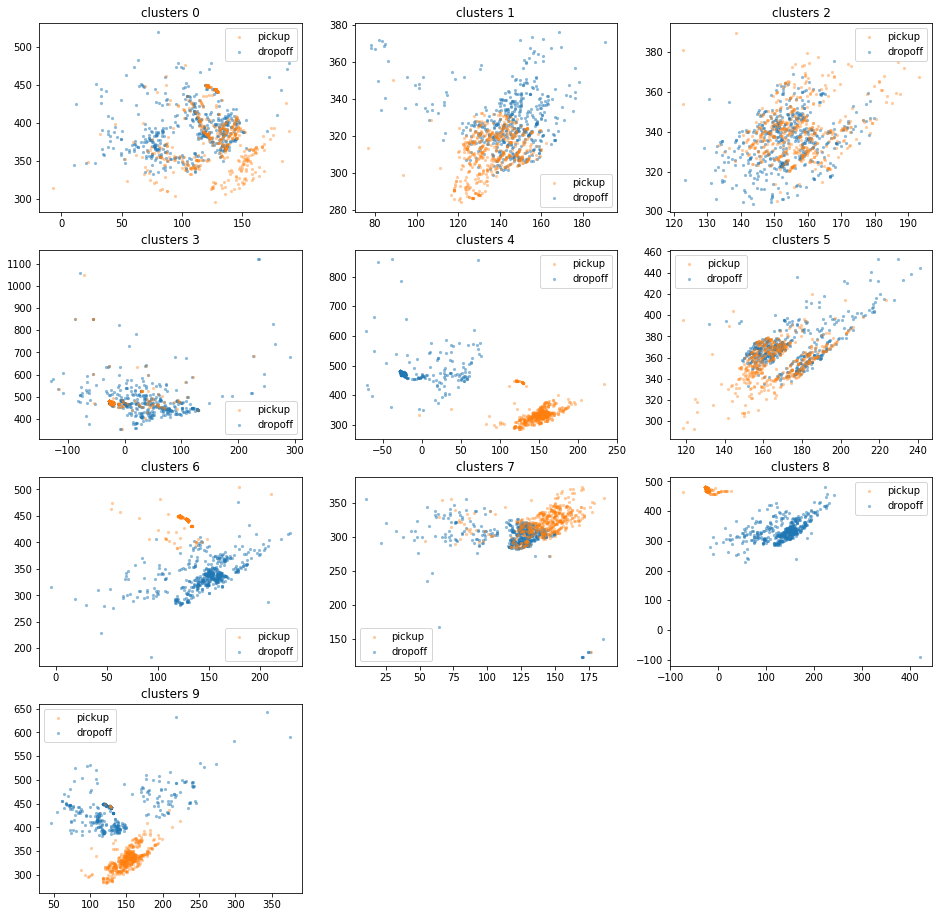

In [103]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = train[train.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_x'][:N], tmp_data['dropoff_y'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_x'][:N], tmp_data['pickup_y'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

#Check Outliers

Text(0, 0.5, 'frequency')

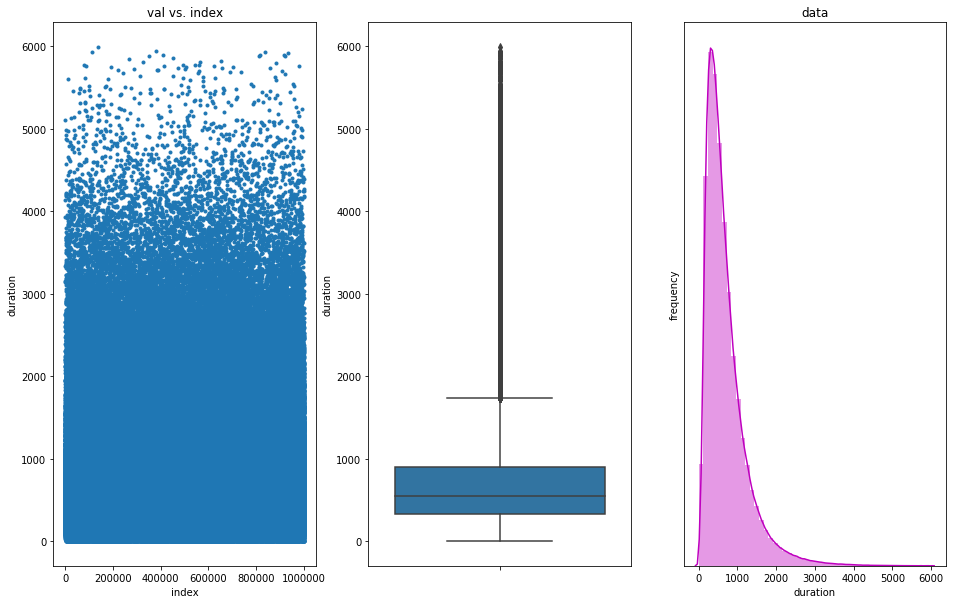

In [104]:
y = np.array(train.duration)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=train.duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

#Outliers - Trip Duration

In [105]:
y = np.array(train.duration)

In [106]:
outliers_trip_duration=np.array([False]*len(train))

In [107]:
outliers_trip_duration[y<30] = True

In [108]:
sum(outliers_trip_duration)

3811

In [109]:
train['outliers_trip_duration'] = outliers_trip_duration

In [110]:
train.shape

(1000000, 17)

In [111]:
#Drop trip_duration outliers
# Get names of indexes for which column outlier_trip_duration has value 'True'
indexNames = train[ train['outliers_trip_duration'] == True ].index
 
# Delete these row indexes from dataFrame
train.drop(indexNames , inplace=True)

#Outliers-Speed

In [112]:
kph = train.Distance/1000/train.duration*3600

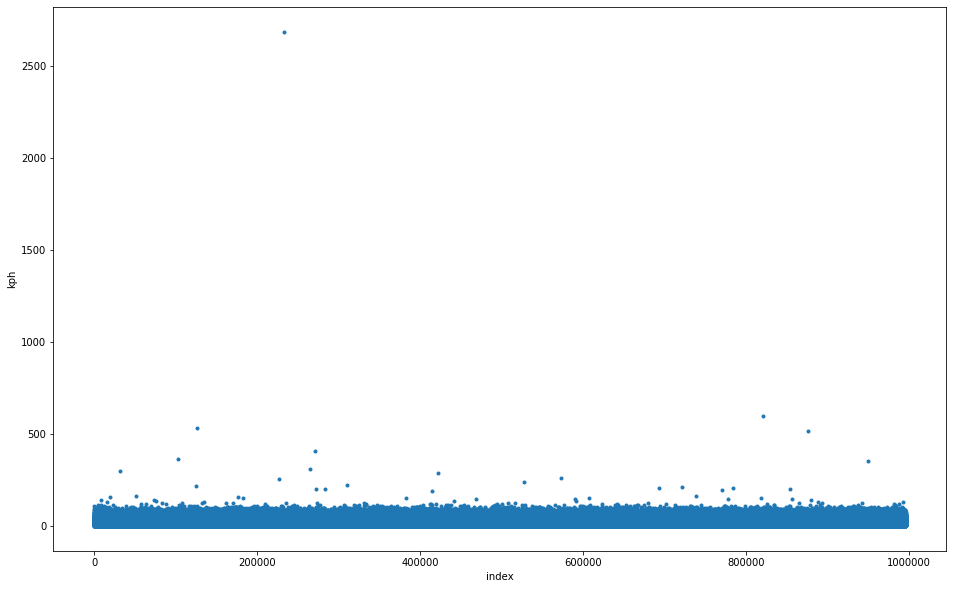

In [113]:
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

In [114]:
outliers_speed=np.array([False]*len(train))

In [115]:
outliers_speed[kph>120] = True

In [116]:
sum(outliers_speed)

65

In [117]:
train['outliers_speed'] = outliers_speed

In [118]:
train.shape

(996189, 18)

In [119]:
#Drop speed outliers
# Get names of indexes for which column outlier_speed has value 'True'
indexNames = train[train['outliers_speed'] == True ].index
 
# Delete these row indexes from dataFrame
train.drop(indexNames , inplace=True)

#Modeling

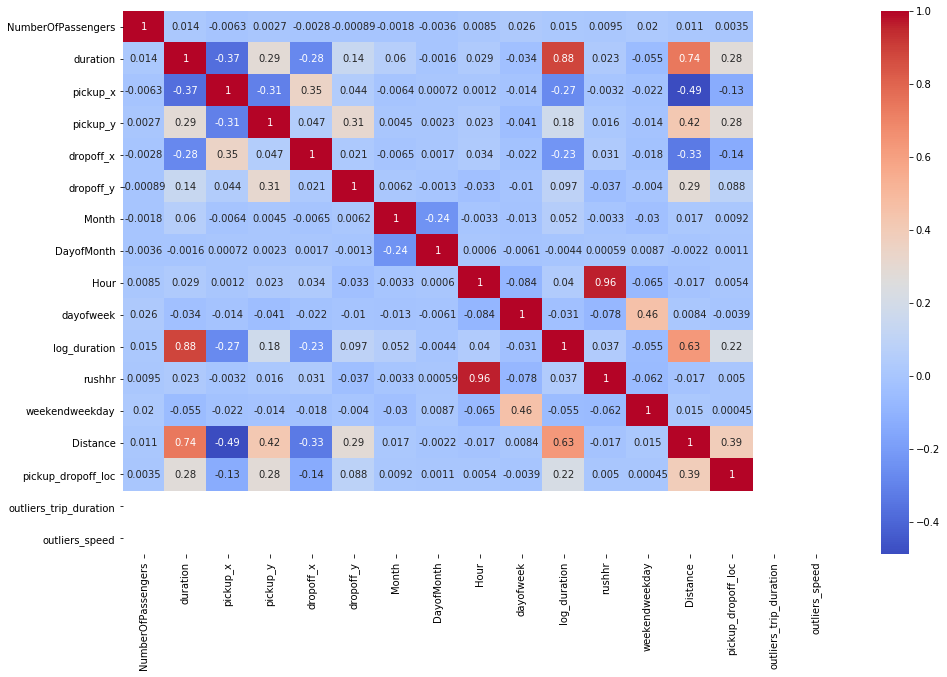

In [120]:
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

In [121]:
traindf = train[['Distance','dayofweek','Hour', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y'  ]]

testdf = test[['Distance','dayofweek','Hour', 'pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y' ]]

In [122]:
X = traindf
z = train.log_duration.values
#z = train.duration.values

In [123]:
import xgboost as xgb

In [124]:
from sklearn.model_selection import train_test_split

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [125]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.05,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

In [126]:
model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[20:30:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5.54883	valid-rmse:5.55007
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[100]	train-rmse:0.36243	valid-rmse:0.36518
[200]	train-rmse:0.34786	valid-rmse:0.35376
[300]	train-rmse:0.34017	valid-rmse:0.34864
[400]	train-rmse:0.33531	valid-rmse:0.34580
[500]	train-rmse:0.33227	valid-rmse:0.34466
[600]	train-

In [128]:
#For Cross Validation Graph
cv_results = xgb.cv(
    parms,
    data_cv,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)

[20:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:43:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language b

In [60]:
cv_results['test-mae-mean'].min()

0.2570456

In [ ]:
#Create CV Graph

In [176]:
data_test = xgb.DMatrix(Xval)
ztest = model.predict(data_test)

In [177]:
ytest = np.expm1(ztest)
print(ytest[:10])

[ 677.6078   584.5971   888.61743  392.54874 1813.3894  1093.6442
  342.28992  992.1136   431.16013  396.45044]


In [ ]:
from sklearn.metrics import mean_absolute_error

In [66]:
# "Learn" the mean from the training data
mean_train = np.mean(z)
# Get predictions on the test set
baseline_predictions = np.ones(ztest.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(ytest, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 239.08


In [138]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

print(metrics.mean_squared_error(ytest, ztest))
print(np.sqrt(metrics.mean_squared_error(ytest,ztest)))

87485.72
295.77985


## Don't Run-Hyperparameter Tuning

In [45]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(8,12)
]

In [46]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    parms['max_depth'] = max_depth
    parms['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        parms,
        data_cv,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=6, min_child_weight=8
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/software/hadoop/python36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.28999559999999996 for 202 rounds
CV with max_depth=6, min_child_weight=9
[13:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2901306 for 226 rounds
CV with max_depth=6, min_child_weight=10
[13:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now d

In [50]:
# tuning eta 
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    parms['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(parms,
                                data_cv,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics=['mae'],
                                early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 31.5 µs
CV with eta=0.3
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/software/hadoop/python36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.2888112 for 126 rounds

CV with eta=0.2
[14:04:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:04:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.2846876 for 237 rounds

CV with eta=0.1
[14:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:06:07] WARNIN

In [144]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\nimee\anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    lightgbm-2.3.1             |   py37h6538335_0         559 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.6 MB

The following NEW packages will be INSTALLED:

  lightgbm           conda-forge/win-64::lightgbm-2.3.1-py37h6538335_0
  python_abi         conda-forge/win-64::python_abi-3.7-1_cp37m

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1




python

In [146]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=35, n_estimators=300)
lgb_model.fit(Xtrain, Ztrain)
y_LGB_predict = lgb_model.predict(Xval)
LGB_model_error = sqrt(mean_squared_error(np.expm1(Zval), np.expm1(y_LGB_predict)))
print(f'LGBM Mean Squared Error - {LGB_model_error}')

LGBM Mean Squared Error - 255.1416064712437


In [156]:
ztest.shape

(199225,)

In [151]:
y_LGB_predict.shape

(199225,)

In [178]:
#XGB & LGB - weights 
ensembled_prediction = (0.5*np.expm1(ztest))+(0.5*np.expm1(y_LGB_predict))
ensembled_prediction_error = sqrt(mean_squared_error(np.expm1(Zval), ensembled_prediction))
print(f'Ensembled Mean Squared Error - {ensembled_prediction_error}')

Ensembled Mean Squared Error - 249.0645965923679


In [191]:
#XGB & LGB
ensembled_prediction = (0.9*np.expm1(ztest))+(0.1*np.expm1(y_LGB_predict))
ensembled_prediction_error = sqrt(mean_squared_error(np.expm1(Zval), ensembled_prediction))
print(f'Ensembled Mean Squared Error - {ensembled_prediction_error}')

Ensembled Mean Squared Error - 246.4154862376901


# Prediction on Test Data

In [184]:
#XGB Prediction
data_test = xgb.DMatrix(testdf)
ytest = model.predict(data_test)

In [185]:
#LGB Prediction
y_LGB_test_predict = lgb_model.predict(testdf)

In [186]:
#Ensemble Prediction
ypred = (0.5*np.expm1(ytest))+(0.5*np.expm1(y_LGB_test_predict))
print(ypred[:10])

[ 503.78515188 1114.38454234  892.87804195  657.55515747  503.01824826
 1986.00937499  207.37235585  228.06451852  406.91002417 1194.38499826]


In [187]:
#Create a data frame for submission
submission = pd.DataFrame({'duration': ypred})
submission.head()

,duration
0,503.785152
1,1114.384542
2,892.878042
3,657.555157
4,503.018248


In [129]:
test.head()

,pickup_datetime,NumberOfPassengers,pickup_x,pickup_y,dropoff_x,dropoff_y,Month,DayofMonth,Hour,dayofweek,rushhr,weekendweekday,Distance,pickup_dropoff_loc
0,2034-03-14 08:28:17,2,155.108652,322.284140,148.058424,332.814003,3,14,8,1,2,0,1845.786703,2
1,2034-04-20 09:04:41,1,146.628808,306.343423,154.284090,339.899155,4,20,9,3,2,0,3953.483139,1
2,2034-01-25 00:46:04,2,132.028079,319.183942,149.318583,384.810789,1,25,0,2,1,0,6653.385487,1
3,2034-02-01 22:20:46,2,175.776769,344.277029,159.039740,311.756787,2,1,22,2,4,0,5467.068525,2
4,2034-04-15 23:29:21,2,128.428489,295.153348,126.011933,309.548102,4,15,23,5,4,1,1261.947305,1


In [127]:
testdf.head()

,Distance,dayofweek,Hour,pickup_x,pickup_y,dropoff_x,dropoff_y
0,1845.786703,1,8,155.108652,322.284140,148.058424,332.814003
1,3953.483139,3,9,146.628808,306.343423,154.284090,339.899155
2,6653.385487,2,0,132.028079,319.183942,149.318583,384.810789
3,5467.068525,2,22,175.776769,344.277029,159.039740,311.756787
4,1261.947305,5,23,128.428489,295.153348,126.011933,309.548102


In [189]:
#Create a csv out of the submission data frame
submission.to_csv("G1.csv", index=False)